In [242]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator


from scipy import stats
import math
from numpy import load

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error


%matplotlib inline

Process: 

1. Training data: __7th March - 22nd Sept 2020 (200 days)__

2. Prediction: __23rd Sept - 31st Dec 2020 (100 days)__ => delta binary vector for from this period

3. Testing: __1st Jan - 5th Feb 2021 (36 days)__

L is found for Prediction period
L^ is found for Prediction period using delta vector

 ---- The model predicts 1 day ahead each time (?)

Finding best th-lag is done with L and L^ for 100 days 

Testing period using best th-lag combination: __1st Jan - 5th Feb 2021 (36 days)__

In [3]:
F = pd.read_csv('data/current/2020_country_daily_2020_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Common cold', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache','symptom:Myalgia', 'symptom:Nausea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F.columns = ['date', 'open_covid_region_code', 'symptom:Common cold', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache','symptom:Myalgia', 'symptom:Nausea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F = F[F['open_covid_region_code'].notna()]
F = F.sort_values(by=['open_covid_region_code'])
F = F.fillna(0)

In [4]:
F_2021 = pd.read_csv('data/current/2021_country_daily_2021_US_daily_symptoms_dataset.csv')[['date', 'sub_region_1_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']]
F_2021.columns = ['date', 'open_covid_region_code', 'symptom:Ageusia', 'symptom:Anosmia', 'symptom:Arthralgia', 'symptom:Clouding of consciousness', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache', 'symptom:Myalgia', 'symptom:Nausea', 'symptom:Nosebleed', 'symptom:Rhinorrhea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
F_2021 = F_2021[F_2021['open_covid_region_code'].notna()]
F_2021 = F_2021.sort_values(by=['open_covid_region_code'])
F_2021 = F_2021.fillna(0)

In [5]:
actual_cases = pd.read_csv('data/all-states-history.csv')[['date','state','positiveIncrease']]

In [6]:
# EXLCUDING: AS(America Samoa), GU(Guam), MP(Northern Mariana Islands), PR(Puerto Rico), VI(Virgin Islands)
OVERLAPPING_STATES = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 
                      'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 
                      'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

actual_cases = actual_cases[actual_cases['state'].isin(OVERLAPPING_STATES)]
unique_dates = actual_cases['date'].unique()

lacking = []
for date in unique_dates:
    if len(actual_cases[actual_cases.date == date]) == 51:
        continue
    else: 
        lacking.append(date)
        
print("last date without full 51 states: ", max(lacking))
actual_cases = actual_cases[actual_cases.date > '2020-03-06'].sort_values(by=['date', 'state'], ascending=True)

last date without full 51 states:  2020-03-06


In [7]:
NUM_STATES = F.open_covid_region_code.nunique()
assert NUM_STATES == 51, "NUM_STATES ERROR"
STATES = F.open_covid_region_code.unique()
SYMP_LIST = ['symptom:Common cold', 'symptom:Cough', 'symptom:Diarrhea', 'symptom:Fatigue', 'symptom:Fever', 'symptom:Headache',
             'symptom:Myalgia', 'symptom:Nausea', 'symptom:Shortness of breath', 'symptom:Skin rash', 'symptom:Sore throat', 'symptom:Vomiting']
NUM_SYMP = len(SYMP_LIST)

In [168]:
F_training = F[(F.date >= "2020-03-07") & (F.date <= "2020-09-22")]
F_testing = F[(F.date >= "2020-09-23") & (F.date <= "2020-12-31")]

## ARIMA: FEVER (CT)

In [173]:
target = "US-CT"
symptom = "symptom:Fever"

symptoms = F_training.sort_values(by=['date', 'open_covid_region_code'], ascending=True)
symptoms = symptoms.set_index('open_covid_region_code')
X = symptoms.loc[target][symptom]

test_symptoms = F_testing.sort_values(by=['date', 'open_covid_region_code'], ascending=True)
test_symptoms = test_symptoms.set_index('open_covid_region_code')
Y = test_symptoms.loc[target][symptom]

In [240]:
# Why does the dfu test indicate that the series is stationary when it is not?
per = 1
print(" > Is the data stationary ?")
dftest = adfuller(X.diff(periods=per)[per:], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value =  {:.15f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.144
P-value =  0.023484229907579
Critical values :
	1%: -3.466398230774071 - The data is not stationary with 99% confidence
	5%: -2.8773796387256514 - The data is  stationary with 95% confidence
	10%: -2.575213838610586 - The data is  stationary with 90% confidence


Figuring out the hyperparameters

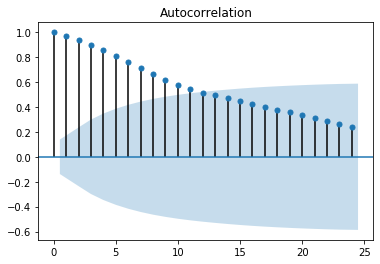

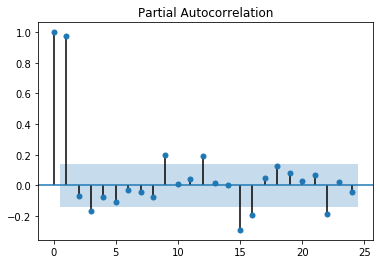

In [243]:
# if it is slowly decaying, then the series is not stationary
acf_plot = plot_acf(X)
pacf_plot = plot_pacf(X)

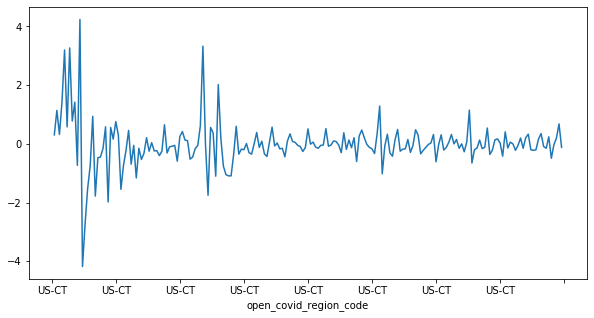

In [187]:
fig, ax = plt.subplots(figsize=(10,5))
X_diff.plot()

/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


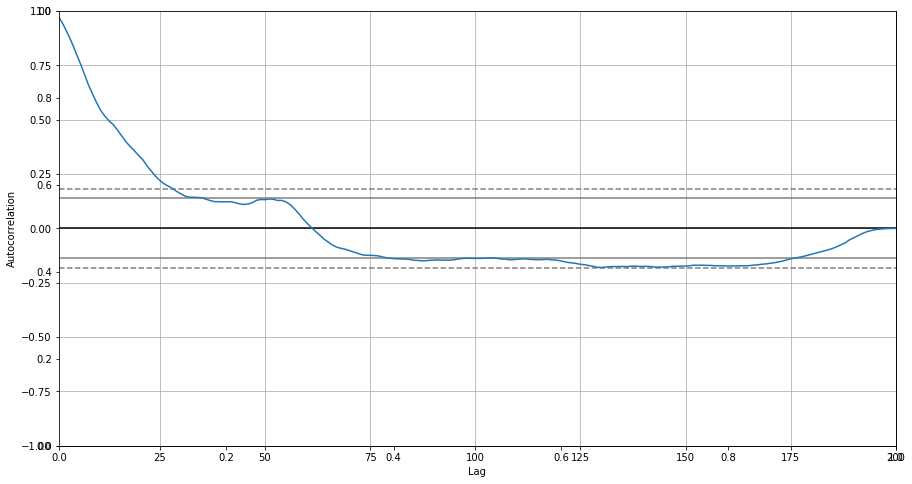

In [188]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(15,8))
autocorrelation_plot(X)
# p value can be 47 - 60

In [288]:
ar_model = ARIMA(X.values, order=(11,1,3))
ar_model_fit = ar_model.fit()
print(ar_model_fit.aic)

463.6429690117642


/Users/nadhirahrafidz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [289]:
print(ar_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                ARIMA(11, 1, 3)   Log Likelihood                -216.821
Date:                Tue, 30 Mar 2021   AIC                            463.643
Time:                        21:24:35   BIC                            513.043
Sample:                             0   HQIC                           483.636
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2630      0.096      2.737      0.006       0.075       0.451
ar.L2          0.1613      0.103      1.562      0.118      -0.041       0.364
ar.L3         -0.6861      0.098     -7.001      0.0

In [290]:
pred = ar_model_fit.forecast(1, alpha=0.05)
print(pred)
print(Y[0])

[4.27088492]
4.08


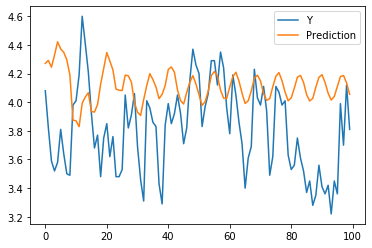

In [291]:
plt.plot(Y.values, label="Y")
plt.plot(ar_model_fit.forecast(100, alpha=0.05), label="Prediction")
plt.legend()

In [292]:
mean_squared_error(Y.values, ar_model_fit.forecast(100, alpha=0.05))

0.19298366892757873

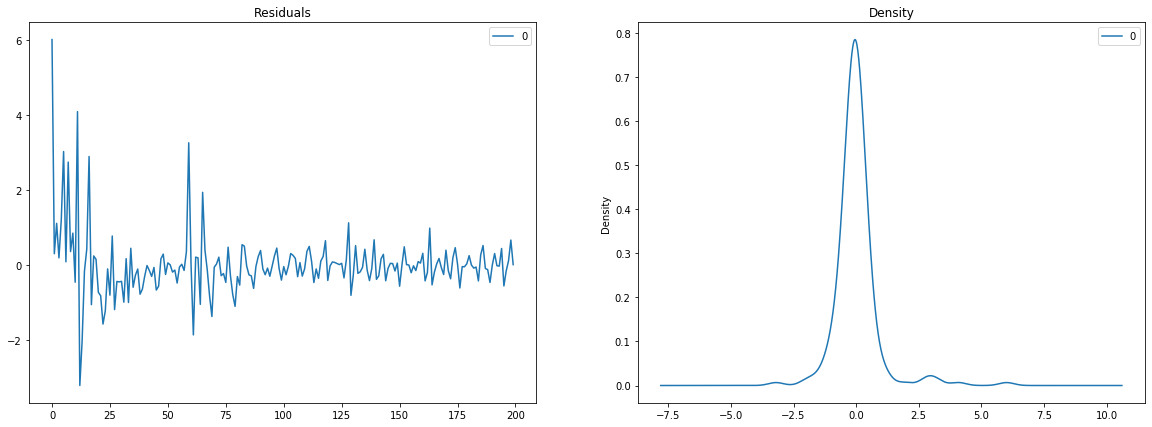

In [293]:
residuals = pd.DataFrame(ar_model_fit.resid)
fig, ax = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(20)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [294]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(ar_model_fit.forecast(100, alpha=0.05), Y)


{'mape': 0.10036538635435792,
 'me': 0.3030465724726308,
 'mae': 0.364063255946486,
 'mpe': 0.08621241850531755,
 'rmse': 0.43929906547542147,
 'corr': 0.0282736634378617,
 'minmax': 0.08773343462177396}